In [1]:
from pydicom import dcmread
from pydicom.fileset import FileSet
from pathlib import Path

import glob
import pandas as pd

def genOPTfs(fs):
    for instance in fs.find(Modality='OPT'):
        ds = instance.load()
        yield ds
        #print(ds.PatientID,ds.ImageLaterality,ds.SeriesDate,)



def genOPfs(fs):
    for instance in fs.find(Modality='OP'):
        ds = instance.load()
        yield ds



In [41]:
from PIL import Image
import os
import shutil


dirgen = glob.iglob('/data/amd-data/cera-rpddata/Himeesh DICOM/*/DICOMDIR')
rootdir = '/data/amd-data/cera-rpd/Test_dicom_extracted'
if not os.path.exists(rootdir):
    os.mkdir(rootdir)
keywords = ['SOPInstanceUID',
    'PatientID', 
    'ImageLaterality', 
    'SeriesDate'
]

frame_measures = ['slicei','img_path','msk_path']
list_of_dicts = []
for dsstr in dirgen:
    fs = FileSet(dcmread(dsstr))
    fsgenOPT = genOPTfs(fs)
    for fi in fsgenOPT:
        dd=dict()
        #top level keywords
        for key in keywords:
            dd[key] = fi.get(key)

        volpath = os.path.join(rootdir, f'{fi.PatientID}_{fi.ImageLaterality}') #path for volume
        shutil.rmtree(volpath,ignore_errors=True)
        os.mkdir(volpath)
        #dd['volID'] = f'{fi.PatientID}_{fi.ImageLaterality}'

        n = fi.NumberOfFrames
        for i in range(n):
            dd['slicei'] = i
            #save pixel array as png
            fname = os.path.join(volpath,f'{fi.PatientID}_{fi.ImageLaterality}_oct-{i:03d}.png')
            dd['img_path'] = fname
            Image.fromarray(fi.pixel_array[i]).save(fname)
            list_of_dicts.append(dd.copy())

dfoct = pd.DataFrame(list_of_dicts, columns = keywords+frame_measures)

In [42]:
dfoct = dfoct.assign(volID = dfoct.PatientID+'_'+dfoct.ImageLaterality).assign(fold = 'dicom')

In [53]:
dfclean = dfoct[~dfoct.volID.isin(['101002_R','101092_L'])]
dfclean

,SOPInstanceUID,PatientID,ImageLaterality,SeriesDate,slicei,img_path,msk_path,volID,fold
48,1.3.6.1.4.1.33437.11.4.254764.85672115827858.24956.4.1,101002,L,20120802,0,/data/amd-data/cera-rpd/Test_dicom_extracted/101002_L/101002_L_oct-000.png,NaN,101002_L,dicom
49,1.3.6.1.4.1.33437.11.4.254764.85672115827858.24956.4.1,101002,L,20120802,1,/data/amd-data/cera-rpd/Test_dicom_extracted/101002_L/101002_L_oct-001.png,NaN,101002_L,dicom
50,1.3.6.1.4.1.33437.11.4.254764.85672115827858.24956.4.1,101002,L,20120802,2,/data/amd-data/cera-rpd/Test_dicom_extracted/101002_L/101002_L_oct-002.png,NaN,101002_L,dicom
51,1.3.6.1.4.1.33437.11.4.254764.85672115827858.24956.4.1,101002,L,20120802,3,/data/amd-data/cera-rpd/Test_dicom_extracted/101002_L/101002_L_oct-003.png,NaN,101002_L,dicom
52,1.3.6.1.4.1.33437.11.4.254764.85672115827858.24956.4.1,101002,L,20120802,4,/data/amd-data/cera-rpd/Test_dicom_extracted/101002_L/101002_L_oct-004.png,NaN,101002_L,dicom
...,...,...,...,...,...,...,...,...,...
13758,1.3.6.1.4.1.33437.11.4.254764.9994792147857.25042.4.1,102048,R,20150210,44,/data/amd-data/cera-rpd/Test_dicom_extracted/102048_R/102048_R_oct-044.png,NaN,102048_R,dicom
13759,1.3.6.1.4.1.33437.11.4.254764.9994792147857.25042.4.1,102048,R,20150210,45,/data/amd-data/cera-rpd/Test_dicom_extracted/102048_R/102048_R_oct-045.png,NaN,102048_R,dicom
13760,1.3.6.1.4.1.33437.11.4.254764.9994792147857.25042.4.1,102048,R,20150210,46,/data/amd-data/cera-rpd/Test_dicom_extracted/102048_R/102048_R_oct-046.png,NaN,102048_R,dicom
13761,1.3.6.1.4.1.33437.11.4.254764.9994792147857.25042.4.1,102048,R,20150210,47,/data/amd-data/cera-rpd/Test_dicom_extracted/102048_R/102048_R_oct-047.png,NaN,102048_R,dicom


In [48]:
dfclean.to_csv(os.path.join(rootdir,'dataframe.csv'))

In [49]:
keywords = ['SOPInstanceUID',
    'PatientID', 
    'ImageLaterality', 
    'SeriesDate',
    'NumberOfFrames',
    'Rows',
    'Columns',
    'FrameOfReferenceUID',
    'SynchronizationFrameOfReferenceUID' 
]
shared_measures = [
    'ReferencedSOPInstanceUID', #OP image for reference cooridnates
    'PixelSpacing',
    'SliceThickness',
]

frame_measures = [
    'slicei',
    'ReferenceCoordinates'
]
list_of_dicts = []
dirgen = glob.iglob('/data/amd-data/cera-rpddata/Himeesh DICOM/*/DICOMDIR')
for dsstr in dirgen:
    fs = FileSet(dcmread(dsstr))
    fsgenOPT = genOPTfs(fs)
    for fi in fsgenOPT:

        dd=dict()

        #top level keywords
        for key in keywords:
            dd[key] = fi.get(key)

        #SharedFunctionalGroupsSequence
        dd['ReferencedSOPInstanceUID'] = fi.SharedFunctionalGroupsSequence[0].ReferencedImageSequence[0].ReferencedSOPInstanceUID
        dd['SliceThickness'] = fi.SharedFunctionalGroupsSequence[0].PixelMeasuresSequence[0].SliceThickness
        dd['PixelSpacing'] = fi.SharedFunctionalGroupsSequence[0].PixelMeasuresSequence[0].PixelSpacing

        #PerFrameFunctionalGroupsSequence
        seq = fi.PerFrameFunctionalGroupsSequence



        dd['ReferenceCoordinates'] = [item.OphthalmicFrameLocationSequence[0].ReferenceCoordinates for item in seq]
        dd['slicei'] = [item.FrameContentSequence[0].InStackPositionNumber-1 for item in seq]

        list_of_dicts.append(dd) #dictionary recreated each time

dfOPT = pd.DataFrame(list_of_dicts, columns = keywords+shared_measures+frame_measures)
dfOPT = dfOPT.explode(['slicei','ReferenceCoordinates'],ignore_index=True)

In [50]:
fsgenOP = genOPfs(fs)

keywords = ['SOPInstanceUID',
    'PatientID', 
    'ImageLaterality', 
    'SeriesDate',
    'NumberOfFrames',
    'Rows',
    'Columns',
    'FrameOfReferenceUID',
    'SynchronizationFrameOfReferenceUID',
    'HorizontalFieldOfView',
    'PixelSpacing' 
]

list_of_dicts=[]
dirgen = glob.iglob('/data/amd-data/cera-rpddata/Himeesh DICOM/*/DICOMDIR')
for dsstr in dirgen:
    fs = FileSet(dcmread(dsstr))
    fsgenOP = genOPfs(fs)
    for fi in fsgenOP:
        dd=dict()

        #top level keywords
        for key in keywords:
            dd[key] = fi.get(key)

        list_of_dicts.append(dd) #dictionary recreated each time
dfOP = pd.DataFrame(list_of_dicts,columns = keywords)   


In [51]:
dfOPT.astype('str').to_parquet(os.path.join(rootdir,'dfOPT.parquet'))
dfOP.astype('str').to_parquet(os.path.join(rootdir,'dfOP.parquet'))

In [52]:
#check vol and dicom dataset overlap
dfvol = pd.read_csv('/data/amd-data/cera-rpd/detectron2-rpd/output_ext_test/dfpts_ext_test.csv')
dff = dfOP.replace({'ImageLaterality':{'R':'OD','L':'OS'}})
dff['volID'] = dff['PatientID'].str.cat(dff['ImageLaterality'],sep='_')
dfjoin = dff[['volID','SOPInstanceUID']].merge(dfvol['volID'],on='volID',indicator=True,how='outer')
dfjoin[dfjoin.SOPInstanceUID.isna()]
dfjoin

,volID,SOPInstanceUID,_merge
0,101002_OD,1.3.6.1.4.1.33437.11.4.254764.55538625279121.24956.4.0.0,both
1,101002_OD,1.3.6.1.4.1.33437.11.4.254764.5304687860331.24960.4.0.0,both
2,101002_OS,1.3.6.1.4.1.33437.11.4.254764.85672115827855.24956.4.0.0,both
3,101007_OS,1.3.6.1.4.1.33437.11.4.254764.31177570851606.25004.4.0.0,both
4,101007_OD,1.3.6.1.4.1.33437.11.4.254764.48683857550154.25021.4.0.0,both
...,...,...,...
278,102041_OS,1.3.6.1.4.1.33437.11.4.254764.17227517074378.25061.4.0.0,both
279,102048_OS,1.3.6.1.4.1.33437.11.4.254764.17227517074356.25054.4.0.0,both
280,102048_OD,1.3.6.1.4.1.33437.11.4.254764.9994792147854.25042.4.0.0,both
281,102038_OD,NaN,right_only


In [40]:
s = dfOPT[['SOPInstanceUID','PatientID','ImageLaterality','NumberOfFrames']].drop_duplicates()
instances_to_drop = s[s.NumberOfFrames!=49].SOPInstanceUID
dfOPT[~dfOPT.SOPInstanceUID.isin(instances_to_drop)].astype('str').nunique()

SOPInstanceUID                        278
PatientID                             140
ImageLaterality                         2
SeriesDate                            124
NumberOfFrames                          1
Rows                                    1
Columns                                 1
FrameOfReferenceUID                   278
SynchronizationFrameOfReferenceUID      1
ReferencedSOPInstanceUID              278
PixelSpacing                          148
SliceThickness                        160
slicei                                 49
ReferenceCoordinates                  686
dtype: int64

In [ ]:
s = dfOPT.astype('str').groupby('ReferenceCoordinates').count()
s[s.SOPInstanceUID>1].index
pd.DataFrame(dfOPT['ReferenceCoordinates'].tolist()).hist(bins=500)

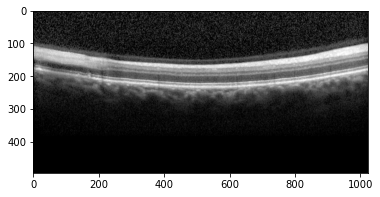

In [134]:
import matplotlib.pyplot as plt
im = Image.open(fname)
plt.imshow(im,cmap='gray')
import numpy as np
imarr = np.array(im)
imarr.shape
imarr.max()

# Make Data #

In [54]:
df = pd.read_csv(os.path.join(rootdir,'dataframe.csv'),index_col=0)


In [55]:
df

,SOPInstanceUID,PatientID,ImageLaterality,SeriesDate,slicei,img_path,msk_path,volID,fold
48,1.3.6.1.4.1.33437.11.4.254764.85672115827858.24956.4.1,101002,L,20120802,0,/data/amd-data/cera-rpd/Test_dicom_extracted/101002_L/101002_L_oct-000.png,NaN,101002_L,dicom
49,1.3.6.1.4.1.33437.11.4.254764.85672115827858.24956.4.1,101002,L,20120802,1,/data/amd-data/cera-rpd/Test_dicom_extracted/101002_L/101002_L_oct-001.png,NaN,101002_L,dicom
50,1.3.6.1.4.1.33437.11.4.254764.85672115827858.24956.4.1,101002,L,20120802,2,/data/amd-data/cera-rpd/Test_dicom_extracted/101002_L/101002_L_oct-002.png,NaN,101002_L,dicom
51,1.3.6.1.4.1.33437.11.4.254764.85672115827858.24956.4.1,101002,L,20120802,3,/data/amd-data/cera-rpd/Test_dicom_extracted/101002_L/101002_L_oct-003.png,NaN,101002_L,dicom
52,1.3.6.1.4.1.33437.11.4.254764.85672115827858.24956.4.1,101002,L,20120802,4,/data/amd-data/cera-rpd/Test_dicom_extracted/101002_L/101002_L_oct-004.png,NaN,101002_L,dicom
...,...,...,...,...,...,...,...,...,...
13758,1.3.6.1.4.1.33437.11.4.254764.9994792147857.25042.4.1,102048,R,20150210,44,/data/amd-data/cera-rpd/Test_dicom_extracted/102048_R/102048_R_oct-044.png,NaN,102048_R,dicom
13759,1.3.6.1.4.1.33437.11.4.254764.9994792147857.25042.4.1,102048,R,20150210,45,/data/amd-data/cera-rpd/Test_dicom_extracted/102048_R/102048_R_oct-045.png,NaN,102048_R,dicom
13760,1.3.6.1.4.1.33437.11.4.254764.9994792147857.25042.4.1,102048,R,20150210,46,/data/amd-data/cera-rpd/Test_dicom_extracted/102048_R/102048_R_oct-046.png,NaN,102048_R,dicom
13761,1.3.6.1.4.1.33437.11.4.254764.9994792147857.25042.4.1,102048,R,20150210,47,/data/amd-data/cera-rpd/Test_dicom_extracted/102048_R/102048_R_oct-047.png,NaN,102048_R,dicom


In [56]:
from data import rpd_data
import pickle

data = rpd_data(df,grp='dicom',data_has_ann=False)
pickle.dump(data, open("ext_test_dicom.pk", "wb"))

13622it [01:20, 168.76it/s]


Found 13622 images
Found 0 instances
Found 0 too few vertices


In [57]:
dat = pickle.load(open('ext_test_dicom.pk','rb'))
dat

[{'file_name': '/data/amd-data/cera-rpd/Test_dicom_extracted/101002_L/101002_L_oct-000.png',
  'height': 496,
  'width': 1024,
  'image_id': '101002_L_000'},
 {'file_name': '/data/amd-data/cera-rpd/Test_dicom_extracted/101002_L/101002_L_oct-001.png',
  'height': 496,
  'width': 1024,
  'image_id': '101002_L_001'},
 {'file_name': '/data/amd-data/cera-rpd/Test_dicom_extracted/101002_L/101002_L_oct-002.png',
  'height': 496,
  'width': 1024,
  'image_id': '101002_L_002'},
 {'file_name': '/data/amd-data/cera-rpd/Test_dicom_extracted/101002_L/101002_L_oct-003.png',
  'height': 496,
  'width': 1024,
  'image_id': '101002_L_003'},
 {'file_name': '/data/amd-data/cera-rpd/Test_dicom_extracted/101002_L/101002_L_oct-004.png',
  'height': 496,
  'width': 1024,
  'image_id': '101002_L_004'},
 {'file_name': '/data/amd-data/cera-rpd/Test_dicom_extracted/101002_L/101002_L_oct-005.png',
  'height': 496,
  'width': 1024,
  'image_id': '101002_L_005'},
 {'file_name': '/data/amd-data/cera-rpd/Test_dicom_e